# Notebook 7: Comparación modelos

## 1. Introducción

La idea es comparar los distintos modelos con la solución numérica actual.

## 2. Librerías y set up

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import h5py
import sys

print("Is Tensorflow using GPU? ", tf.test.is_gpu_available())
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="0"
os.environ["TF_GPU_ALLOCATOR"]="cuda_malloc_async"

# Set data type:
DTYPE = "float32"
tf.keras.backend.set_floatx(DTYPE)

# Set constants
gamma = 1.4

# Set boundary
tmin, tmax, xmin, xmax = 0., 0.2, 0., 1.0

# Lower bounds and Upper bounds.
lb, ub = tf.constant([tmin, xmin], dtype = DTYPE), tf.constant([tmax, xmax], dtype = DTYPE)
# Set random seed for reproducible results.
tf.random.set_seed(0)

2022-08-30 12:11:05.396948: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcudart.so.10.1
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Status size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Datatype size changed, may indicate binary incompatibility. Expected 24 from C header, got 32 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Request size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Prequest size changed, may indicate binary incompatibility. Expected 32 from C header, got 40 from PyObject
<frozen importlib._bootstrap>:228: RuntimeWarning: mpi4py.MPI.Grequest size changed, may indicate binary incompatibility. Expected 40 from C header, got 48 from PyObject
<frozen

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.
Is Tensorflow using GPU?  True


2022-08-30 12:11:07.686397: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-30 12:11:07.688367: I tensorflow/compiler/jit/xla_gpu_device.cc:99] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-08-30 12:11:07.689510: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-08-30 12:11:07.769951: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties: 
pciBusID: 0000:3b:00.0 name: Quadro RTX 6000 computeCapability: 7.5
coreClock: 1.77GHz coreCount: 72 deviceMemorySize: 23.65GiB deviceMemoryBandwidth: 625.94GiB/s
2022-08-30 12:11:07.769987: I tensorflow/stream_executor/platform/default/

## 3. Carga de datos

Cargamos los modelos y las soluciones numéricas.

In [2]:
# Load models:

model_1 = tf.keras.models.load_model("2-PESOS-FIJOS-IGUALES/models/model/")
model_2 = tf.keras.models.load_model("3-PESOS-FIJOS-DIFERENTES/models/model/")
model_3 = tf.keras.models.load_model("4-PESOS-FIJOS-RMSE/models/model/")
model_4 = tf.keras.models.load_model("5-PESOS-FIJOS-RAR/models/model/")
model_5 = tf.keras.models.load_model("6-PESOS-VARIABLES-EXP/models/model/")

In [3]:
# Load numerical resolution:
hf = h5py.File("data/Pyclaw_Classical_Euler_1D_Sod_Tube.h5", "r")
print(hf.keys())
x_PC = np.array(hf.get("x"))
t_PC = np.array(hf.get("times"))
e_PC = np.array(hf.get("e_evolved"))
j_PC = np.array(hf.get("j_evolved"))
rho_PC = np.array(hf.get("rho_evolved"))
hf.close()

<KeysViewHDF5 ['e_evolved', 'j_evolved', 'rho_evolved', 'times', 'x']>


In [4]:
# Calculamos lasvariables primitivas
e_PC_02 = e_PC[e_PC.shape[0]-1,:]
j_PC_02 = j_PC[j_PC.shape[0]-1,:]
rho_PC_02 = rho_PC[rho_PC.shape[0]-1,:]

u_PC_02 = j_PC_02/rho_PC_02
p_PC_02 = (gamma-1)*(e_PC_02 - 0.5*(j_PC_02**2)/rho_PC_02)

## 4. Predicción de modelos

In [5]:
# Construct points and detect with NNs:
x_model = tf.constant(np.linspace(xmin, xmax, x_PC.shape[0]), dtype = DTYPE)
t_model = tf.constant(np.array([tmax for i in range(x_PC.shape[0])]), dtype = DTYPE)

x_model = tf.reshape(x_model, shape = (x_model.shape[0], 1))
t_model = tf.reshape(t_model, shape = (t_model.shape[0], 1))

X_r = tf.concat([t_model, x_model], axis = 1)

# Predictions of models:

pred_1 = model_1(X_r)
rho_model_1, u_model_1, p_model_1 = pred_1[:,0], pred_1[:,1], pred_1[:,2]

pred_2 = model_2(X_r)
rho_model_2, u_model_2, p_model_2 = pred_2[:,0], pred_2[:,1], pred_2[:,2]

pred_3 = model_3(X_r)
rho_model_3, u_model_3, p_model_3 = pred_3[:,0], pred_3[:,1], pred_3[:,2]

pred_4 = model_4(X_r)
rho_model_4, u_model_4, p_model_4 = pred_4[:,0], pred_4[:,1], pred_4[:,2]

pred_5 = model_5(X_r)
rho_model_5, u_model_5, p_model_5 = pred_5[:,0], pred_5[:,1], pred_5[:,2]

2022-08-30 12:11:10.879020: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2022-08-30 12:11:10.902568: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2400000000 Hz
2022-08-30 12:11:10.930250: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcublas.so.10


## 5. Resultados

### 5.1. Comparación predicción momento final

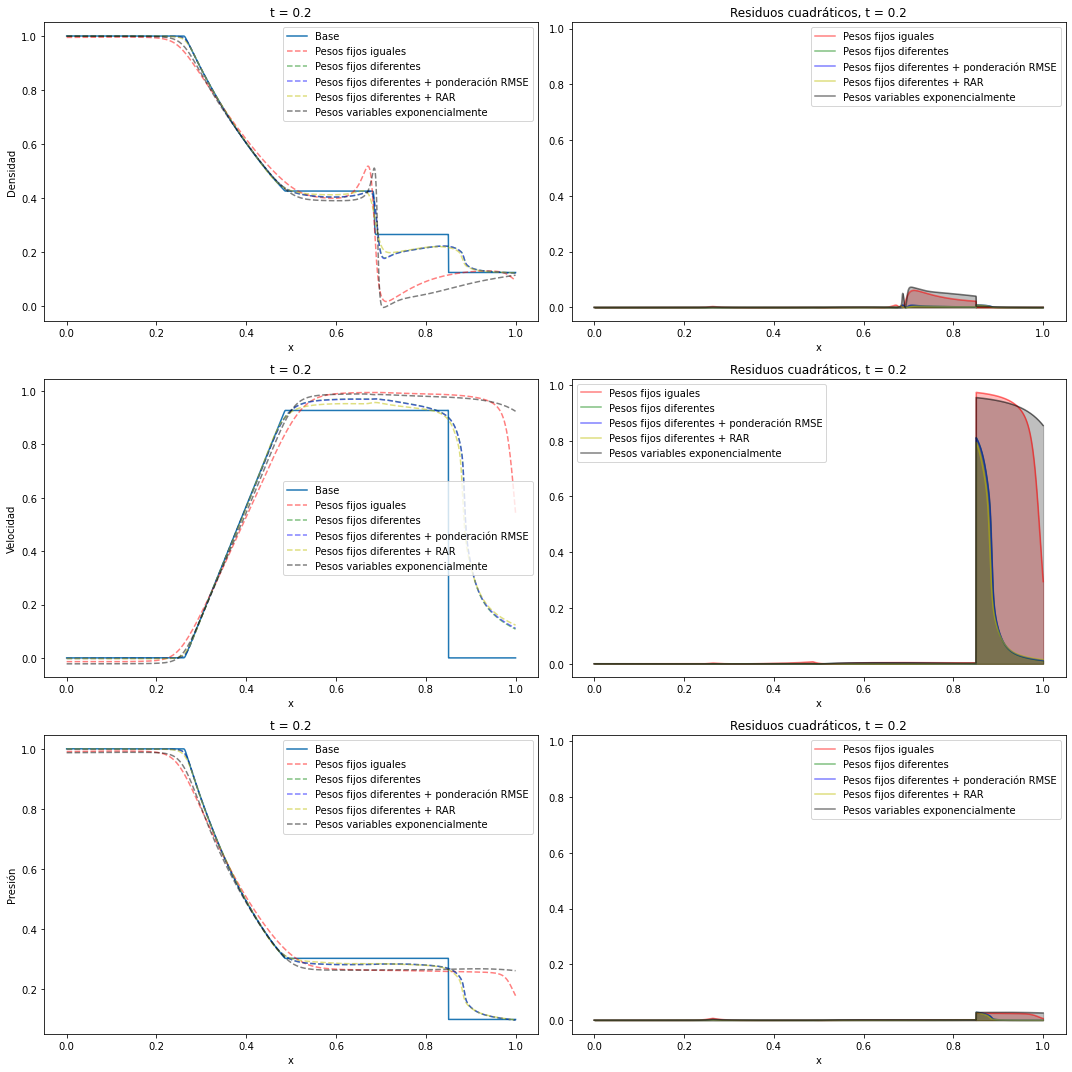

In [6]:
# Comparative plot:
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2)
ax3 = fig.add_subplot(3, 2, 3)
ax4 = fig.add_subplot(3, 2, 4, sharey = ax2)
ax5 = fig.add_subplot(3, 2, 5)
ax6 = fig.add_subplot(3, 2, 6, sharey = ax2)

ax1.plot(x_model, rho_PC_02, label = "Base")
ax1.plot(x_model, rho_model_1, "r--", alpha = 0.5, label = "Pesos fijos iguales")
ax1.plot(x_model, rho_model_2, "g--", alpha = 0.5, label = "Pesos fijos diferentes")
ax1.plot(x_model, rho_model_3, "b--", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax1.plot(x_model, rho_model_4, "y--", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax1.plot(x_model, rho_model_5, "k--", alpha = 0.5, label = "Pesos variables exponencialmente")
ax1.legend()
ax1.set_xlabel("x")
ax1.set_ylabel("Densidad")
ax1.set_title("t = 0.2")

ax2.plot(x_model, (rho_model_1 - rho_PC_02) ** 2, "r", alpha = 0.5, label = "Pesos fijos iguales")
ax2.plot(x_model, (rho_model_2 - rho_PC_02) ** 2, "g", alpha = 0.5, label = "Pesos fijos diferentes")
ax2.plot(x_model, (rho_model_3 - rho_PC_02) ** 2, "b", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax2.plot(x_model, (rho_model_4 - rho_PC_02) ** 2, "y", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax2.plot(x_model, (rho_model_5 - rho_PC_02) ** 2, "k", alpha = 0.5, label = "Pesos variables exponencialmente")
ax2.fill_between(x_model.numpy().squeeze(), ((rho_model_3 - rho_PC_02) ** 2).numpy().squeeze(), color = "b", alpha = 0.25)
ax2.fill_between(x_model.numpy().squeeze(), ((rho_model_1 - rho_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax2.fill_between(x_model.numpy().squeeze(), ((rho_model_2 - rho_PC_02) ** 2).numpy().squeeze(), color = "g", alpha = 0.25)
ax2.fill_between(x_model.numpy().squeeze(), ((rho_model_4 - rho_PC_02) ** 2).numpy().squeeze(), color = "y", alpha = 0.25)
ax2.fill_between(x_model.numpy().squeeze(), ((rho_model_5 - rho_PC_02) ** 2).numpy().squeeze(), color = "k", alpha = 0.25)
ax2.legend()
ax2.set_xlabel("x")
ax2.set_title("Residuos cuadráticos, t = 0.2")

ax3.plot(x_model, u_PC_02, label = "Base")
ax3.plot(x_model, u_model_1, "r--", alpha = 0.5, label = "Pesos fijos iguales")
ax3.plot(x_model, u_model_2, "g--", alpha = 0.5, label = "Pesos fijos diferentes")
ax3.plot(x_model, u_model_3, "b--", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax3.plot(x_model, u_model_4, "y--", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax3.plot(x_model, u_model_5, "k--", alpha = 0.5, label = "Pesos variables exponencialmente")
ax3.legend()
ax3.set_xlabel("x")
ax3.set_ylabel("Velocidad")
ax3.set_title("t = 0.2")

ax4.plot(x_model, (u_model_1 - u_PC_02) ** 2, "r", alpha = 0.5, label = "Pesos fijos iguales")
ax4.plot(x_model, (u_model_2 - u_PC_02) ** 2, "g", alpha = 0.5, label = "Pesos fijos diferentes")
ax4.plot(x_model, (u_model_3 - u_PC_02) ** 2, "b", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax4.plot(x_model, (u_model_4 - u_PC_02) ** 2, "y", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax4.plot(x_model, (u_model_5 - u_PC_02) ** 2, "k", alpha = 0.5, label = "Pesos variables exponencialmente")
ax4.fill_between(x_model.numpy().squeeze(), ((u_model_3 - u_PC_02) ** 2).numpy().squeeze(), color = "b", alpha = 0.25)
ax4.fill_between(x_model.numpy().squeeze(), ((u_model_1 - u_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax4.fill_between(x_model.numpy().squeeze(), ((u_model_2 - u_PC_02) ** 2).numpy().squeeze(), color = "g", alpha = 0.25)
ax4.fill_between(x_model.numpy().squeeze(), ((u_model_4 - u_PC_02) ** 2).numpy().squeeze(), color = "y", alpha = 0.25)
ax4.fill_between(x_model.numpy().squeeze(), ((u_model_5 - u_PC_02) ** 2).numpy().squeeze(), color = "k", alpha = 0.25)
ax4.legend()
ax4.set_xlabel("x")
ax4.set_title("Residuos cuadráticos, t = 0.2")

ax5.plot(x_model, p_PC_02, label = "Base")
ax5.plot(x_model, p_model_1, "r--", alpha = 0.5, label = "Pesos fijos iguales")
ax5.plot(x_model, p_model_2, "g--", alpha = 0.5, label = "Pesos fijos diferentes")
ax5.plot(x_model, p_model_3, "b--", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax5.plot(x_model, p_model_4, "y--", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax5.plot(x_model, p_model_5, "k--", alpha = 0.5, label = "Pesos variables exponencialmente")
ax5.legend()
ax5.set_xlabel("x")
ax5.set_ylabel("Presión")
ax5.set_title("t = 0.2")

ax6.plot(x_model, (p_model_1 - p_PC_02) ** 2, "r", alpha = 0.5, label = "Pesos fijos iguales")
ax6.plot(x_model, (p_model_2 - p_PC_02) ** 2, "g", alpha = 0.5, label = "Pesos fijos diferentes")
ax6.plot(x_model, (p_model_3 - p_PC_02) ** 2, "b", alpha = 0.5, label = "Pesos fijos diferentes + ponderación RMSE")
ax6.plot(x_model, (p_model_4 - p_PC_02) ** 2, "y", alpha = 0.5, label = "Pesos fijos diferentes + RAR")
ax6.plot(x_model, (p_model_5 - p_PC_02) ** 2, "k", alpha = 0.5, label = "Pesos variables exponencialmente")
ax6.fill_between(x_model.numpy().squeeze(), ((p_model_3 - p_PC_02) ** 2).numpy().squeeze(), color = "b", alpha = 0.25)
ax6.fill_between(x_model.numpy().squeeze(), ((p_model_1 - p_PC_02) ** 2).numpy().squeeze(), color = "r", alpha = 0.25)
ax6.fill_between(x_model.numpy().squeeze(), ((p_model_2 - p_PC_02) ** 2).numpy().squeeze(), color = "g", alpha = 0.25)
ax6.fill_between(x_model.numpy().squeeze(), ((p_model_4 - p_PC_02) ** 2).numpy().squeeze(), color = "y", alpha = 0.25)
ax6.fill_between(x_model.numpy().squeeze(), ((p_model_5 - p_PC_02) ** 2).numpy().squeeze(), color = "k", alpha = 0.25)
ax6.legend()
ax6.set_xlabel("x")
ax6.set_title("Residuos cuadráticos, t = 0.2")

fig.tight_layout()

plt.savefig("figs/final_times.png")

In [7]:
def RMSE(x, y):
    return np.sqrt(np.mean(np.sum((x - y) ** 2)))

tests = ["Pesos fijos iguales", "Pesos fijos diferentes", "Pesos fijos diferentes + ponderación RMSE", "Pesos fijos diferentes + RAR", "Pesos variables exponencialmente"]
RMSE_rho = [RMSE(rho_PC_02, rho_model_1), RMSE(rho_PC_02, rho_model_2), RMSE(rho_PC_02, rho_model_3), RMSE(rho_PC_02, rho_model_4), RMSE(rho_PC_02, rho_model_5)]
RMSE_u = [RMSE(u_PC_02, u_model_1), RMSE(u_PC_02, u_model_2), RMSE(u_PC_02, u_model_3), RMSE(u_PC_02, u_model_4), RMSE(u_PC_02, u_model_5)]
RMSE_p = [RMSE(p_PC_02, p_model_1), RMSE(p_PC_02, p_model_2), RMSE(p_PC_02, p_model_3), RMSE(p_PC_02, p_model_4), RMSE(p_PC_02, p_model_5)]

import pandas as pd

df = pd.DataFrame({"Test": tests, "RMSE_rho": RMSE_rho, "RMSE_u": RMSE_u, "RMSE_p": RMSE_p})
df

,Test,RMSE_rho,RMSE_u,RMSE_p
0,Pesos fijos iguales,7.393826,32.948029,5.848662
1,Pesos fijos diferentes,2.749121,16.068035,2.884214
2,Pesos fijos diferentes + ponderación RMSE,2.754743,16.102789,2.877567
3,Pesos fijos diferentes + RAR,2.444004,15.361990,2.681859
4,Pesos variables exponencialmente,8.610988,33.809139,6.302698


In [8]:
paths = ['2-PESOS-FIJOS-IGUALES/data/data.h5',
         '3-PESOS-FIJOS-DIFERENTES/data/data.h5',
         '4-PESOS-FIJOS-RMSE/data/data.h5',
         '5-PESOS-FIJOS-RAR/data/data.h5',
         '6-PESOS-VARIABLES-EXP/data/data.h5']

losses_total, losses_ic, losses_r = [], [], []

for path in paths:
    try:
        hf = h5py.File(path)
        losses_total.append(np.array(hf.get('loss_hist')))
        losses_ic.append(np.array(hf.get('loss_ic_hist')))
        losses_r.append(np.array(hf.get('loss_r_hist')))
        hf.close()
    except:
        print(f'Error al cargar {path}')
        
losses_total = np.array(losses_total)
losses_ic = np.array(losses_ic)
losses_r = np.array(losses_r)

/tmp/ipykernel_992914/2904574690.py:11: H5pyDeprecationWarning: The default file mode will change to 'r' (read-only) in h5py 3.0. To suppress this warning, pass the mode you need to h5py.File(), or set the global default h5.get_config().default_file_mode, or set the environment variable H5PY_DEFAULT_READONLY=1. Available modes are: 'r', 'r+', 'w', 'w-'/'x', 'a'. See the docs for details.
  hf = h5py.File(path)


### 5.2. Pérdida

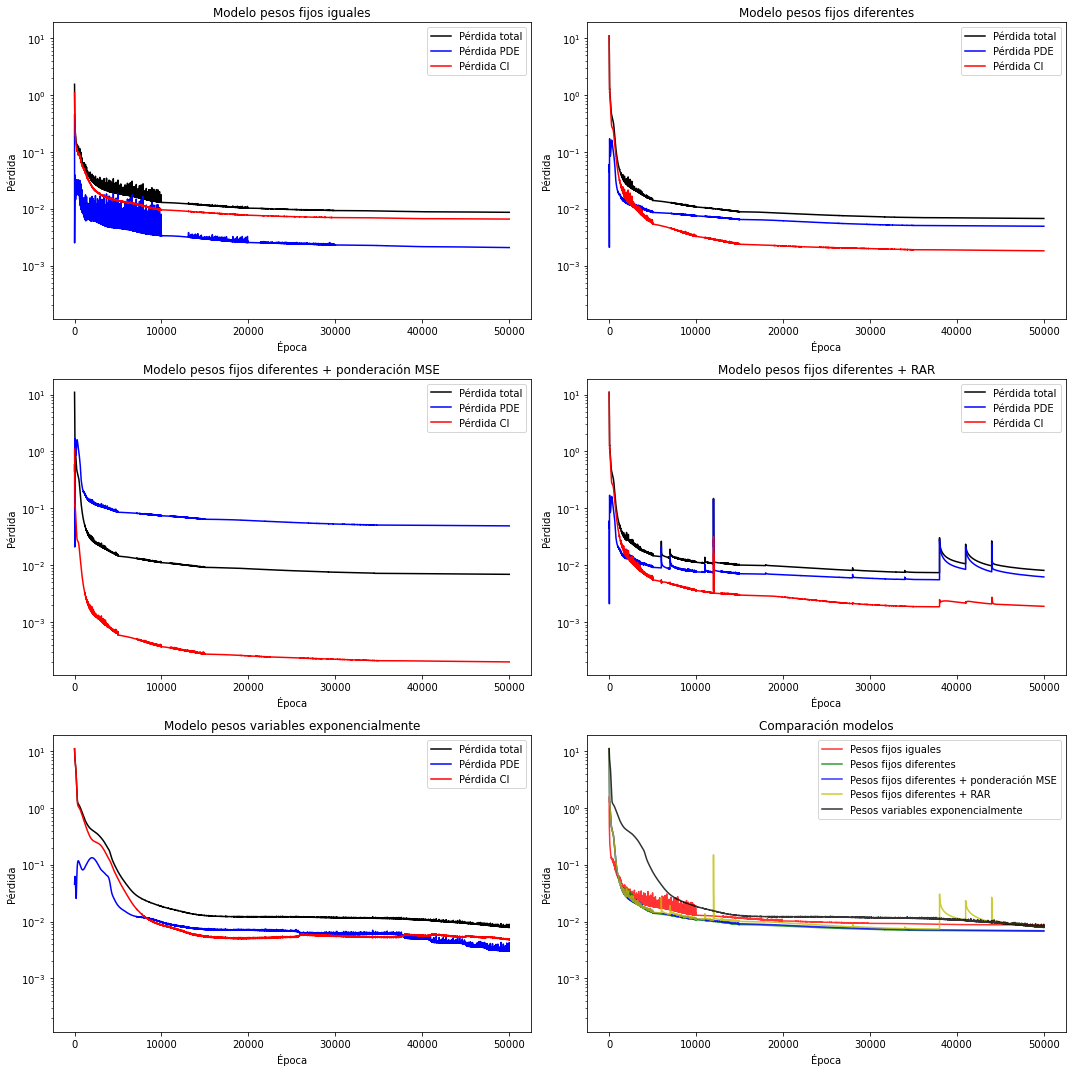

In [11]:
# Comparative plot:
fig = plt.figure(figsize = (15,15))
ax1 = fig.add_subplot(3, 2, 1)
ax2 = fig.add_subplot(3, 2, 2, sharey = ax1)
ax3 = fig.add_subplot(3, 2, 3, sharey = ax1)
ax4 = fig.add_subplot(3, 2, 4, sharey = ax1)
ax5 = fig.add_subplot(3, 2, 5, sharey = ax1)
ax6 = fig.add_subplot(3, 2, 6, sharey = ax1)

ax1.semilogy(losses_total[0], 'k-', label = "Pérdida total")
ax1.semilogy(losses_r[0], 'b-', label = "Pérdida PDE")
ax1.semilogy(losses_ic[0], 'r-', label = "Pérdida CI")
ax1.legend()
ax1.set_xlabel("Época")
ax1.set_ylabel("Pérdida")
ax1.set_title('Modelo pesos fijos iguales')

ax2.semilogy(losses_total[1], 'k-', label = "Pérdida total")
ax2.semilogy(losses_r[1], 'b-', label = "Pérdida PDE")
ax2.semilogy(losses_ic[1], 'r-', label = "Pérdida CI")
ax2.legend()
ax2.set_xlabel("Época")
ax2.set_ylabel("Pérdida")
ax2.set_title('Modelo pesos fijos diferentes')

ax3.semilogy(losses_total[2], 'k-', label = "Pérdida total")
ax3.semilogy(losses_r[2], 'b-', label = "Pérdida PDE")
ax3.semilogy(losses_ic[2], 'r-', label = "Pérdida CI")
ax3.legend()
ax3.set_xlabel("Época")
ax3.set_ylabel("Pérdida")
ax3.set_title('Modelo pesos fijos diferentes + ponderación MSE')

ax4.semilogy(losses_total[3], 'k-', label = "Pérdida total")
ax4.semilogy(losses_r[3], 'b-', label = "Pérdida PDE")
ax4.semilogy(losses_ic[3], 'r-', label = "Pérdida CI")
ax4.legend()
ax4.set_xlabel("Época")
ax4.set_ylabel("Pérdida")
ax4.set_title('Modelo pesos fijos diferentes + RAR')

ax5.semilogy(losses_total[4], 'k-', label = "Pérdida total")
ax5.semilogy(losses_r[4], 'b-', label = "Pérdida PDE")
ax5.semilogy(losses_ic[4], 'r-', label = "Pérdida CI")
ax5.legend()
ax5.set_xlabel("Época")
ax5.set_ylabel("Pérdida")
ax5.set_title('Modelo pesos variables exponencialmente')

ax6.semilogy(losses_total[0], 'r', alpha = 0.8, label = "Pesos fijos iguales")
ax6.semilogy(losses_total[1], 'g', alpha = 0.8, label = "Pesos fijos diferentes")
ax6.semilogy(losses_total[2], 'b', alpha = 0.8, label = "Pesos fijos diferentes + ponderación MSE")
ax6.semilogy(losses_total[3], 'y', alpha = 0.8, label = "Pesos fijos diferentes + RAR")
ax6.semilogy(losses_total[4], 'k', alpha = 0.8, label = "Pesos variables exponencialmente")
ax6.legend()
ax6.set_xlabel("Época")
ax6.set_ylabel("Pérdida")
ax6.set_title('Comparación modelos')


fig.tight_layout()

plt.savefig("figs/losses.png")